Tokenizing comments: 100%|██████████| 18364/18364 [00:10<00:00, 1792.26it/s]



Token Length Statistics:
Mean Length: 40.38
Median Length: 27.00
Max Length: 3135
Min Length: 3
95th Percentile: 112.00


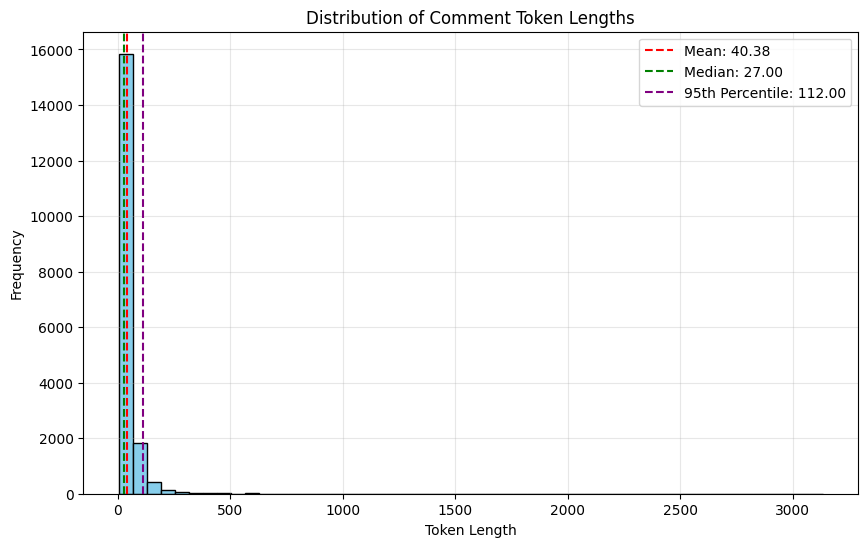

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import BertTokenizer, BertModel
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

import random
import numpy as np

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# 1. Load dataset
# Read CSV file containing YouTube comments
df = pd.read_csv('YoutubeCommentsDataSet.csv')
# Remove rows with missing comments
df = df.dropna(subset=['Comment'])  
# Convert comments to list for processing
comments = df['Comment'].tolist()

# 2. Initialize tokenizer
# Use pre-trained BERT base model (uncased version)
PRETRAINED_MODEL = 'bert-base-uncased'  
# Load tokenizer with specified pre-trained model
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)

# 3. Calculate token lengths for each comment
token_lengths = []
# Process comments with progress bar
for comment in tqdm(comments, desc="Tokenizing comments"):
    # Tokenize comment without truncation
    encoding = tokenizer(
        str(comment),
        truncation=False,  # Preserve original length
        add_special_tokens=True,  # Include [CLS] and [SEP] tokens
        return_tensors='pt'  # Return PyTorch tensors
    )
    # Get number of tokens from encoded input
    length = encoding['input_ids'].size(1)  
    token_lengths.append(length)

# 4. Calculate statistics
mean_length = np.mean(token_lengths)
median_length = np.median(token_lengths)
max_length = np.max(token_lengths)
min_length = np.min(token_lengths)
percentile_95 = np.percentile(token_lengths, 95)  # 95th percentile

# Print statistical summary
print("\nToken Length Statistics:")
print(f"Mean Length: {mean_length:.2f}")
print(f"Median Length: {median_length:.2f}")
print(f"Max Length: {max_length}")
print(f"Min Length: {min_length}")
print(f"95th Percentile: {percentile_95:.2f}")

# 5. Plot token length distribution histogram
plt.figure(figsize=(10, 6))
# Create histogram with 50 bins
plt.hist(token_lengths, bins=50, color='skyblue', edgecolor='black')
# Add reference lines for key statistics
plt.axvline(mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='green', linestyle='--', label=f'Median: {median_length:.2f}')
plt.axvline(percentile_95, color='purple', linestyle='--', label=f'95th Percentile: {percentile_95:.2f}')

# Configure plot appearance
plt.title('Distribution of Comment Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)  # Add semi-transparent grid
plt.show()  # Display the plot


In [2]:
# 1. Data loading and preprocessing
df = pd.read_csv('YoutubeCommentsDataSet.csv')
df = df.dropna(subset=['Comment', 'Sentiment'])  # Remove missing entries

# Label encoding
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label = {v: k for k, v in label2id.items()}
df['label'] = df['Sentiment'].map(label2id)

# Train/validation split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# 2. Handling class imbalance: class weights and sample weights
class_counts = train_df['label'].value_counts().sort_index().values
num_samples = sum(class_counts)
class_weights = [num_samples / c for c in class_counts]
sample_weights = [class_weights[label] for label in train_df['label']]
class_weights_tensor = torch.FloatTensor(class_weights)

# 3. Dataset and tokenizer
PRETRAINED_MODEL = 'bert-base-uncased'  # Use uncased for English comments
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
MAX_LEN = 128

class CommentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts = df['Comment'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = CommentDataset(train_df, tokenizer, MAX_LEN)
val_dataset = CommentDataset(val_df, tokenizer, MAX_LEN)

# 4. DataLoader (use weighted sampling for training set)
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 5. BERT classification model
class BertClassifier(nn.Module):
    def __init__(self, pretrained_model, num_classes, class_weights=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights) if class_weights is not None else nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]
        x = self.dropout(pooled)
        logits = self.fc(x)
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return logits, loss
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertClassifier(PRETRAINED_MODEL, num_classes=3, class_weights=class_weights_tensor.to(device)).to(device)

# 6. Training configuration
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
EPOCHS = 2  # Adjust based on actual needs

# 7. Training and evaluation functions
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss, total_correct = 0, 0
    for batch in tqdm(loader, desc='Training'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        logits, loss = model(input_ids, attention_mask, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * input_ids.size(0)
        total_correct += (logits.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

def eval_epoch(model, loader):
    model.eval()
    total_loss, total_correct = 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc='Validation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            logits, loss = model(input_ids, attention_mask, labels)
            total_loss += loss.item() * input_ids.size(0)
            preds = logits.argmax(1)
            total_correct += (preds == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return (total_loss / len(loader.dataset),
            total_correct / len(loader.dataset),
            all_labels, all_preds)

# 8. Main training loop
best_acc = 0
best_y_true = None
best_y_pred = None
for epoch in range(EPOCHS):
    print("\n" + "-"*50)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer)
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    val_loss, val_acc, y_true, y_pred = eval_epoch(model, val_loader)
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))
    if val_acc > best_acc:
        best_acc = val_acc
        best_y_true = y_true.copy()
        best_y_pred = y_pred.copy()
        torch.save(model.state_dict(), 'best_bert_sentiment.pth')

print("\n" + "-"*50)
print("Training completed.")
print(f"Best validation accuracy: {best_acc:.4f}")
print("\nFinal best model performance:")
print(classification_report(best_y_true, best_y_pred, target_names=['negative', 'neutral', 'positive']))

# 9. Single sentence prediction function
model.load_state_dict(torch.load('best_bert_sentiment.pth'))
model.eval()
def predict(text):
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=MAX_LEN,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        pred = logits.argmax(1).item()
    return id2label[pred]

# Example
print(predict("I love this channel!"))
print(predict("This is terrible."))



--------------------------------------------------
Epoch 1/2


Training: 100%|██████████| 919/919 [01:31<00:00,  9.99it/s]


Train Loss: 0.3622 | Train Acc: 0.8177


Validation: 100%|██████████| 115/115 [00:12<00:00,  9.02it/s]


Val   Loss: 0.4610 | Val   Acc: 0.8029
              precision    recall  f1-score   support

    negative       0.69      0.84      0.76       467
     neutral       0.61      0.88      0.72       925
    positive       0.99      0.76      0.86      2281

    accuracy                           0.80      3673
   macro avg       0.76      0.83      0.78      3673
weighted avg       0.85      0.80      0.81      3673


--------------------------------------------------
Epoch 2/2


Training: 100%|██████████| 919/919 [01:31<00:00, 10.00it/s]


Train Loss: 0.1680 | Train Acc: 0.9138


Validation: 100%|██████████| 115/115 [00:12<00:00,  9.12it/s]


Val   Loss: 0.5174 | Val   Acc: 0.8380
              precision    recall  f1-score   support

    negative       0.81      0.74      0.77       467
     neutral       0.64      0.89      0.75       925
    positive       0.97      0.84      0.90      2281

    accuracy                           0.84      3673
   macro avg       0.81      0.82      0.81      3673
weighted avg       0.87      0.84      0.84      3673


--------------------------------------------------
Training completed.
Best validation accuracy: 0.8380

Final best model performance:
              precision    recall  f1-score   support

    negative       0.81      0.74      0.77       467
     neutral       0.64      0.89      0.75       925
    positive       0.97      0.84      0.90      2281

    accuracy                           0.84      3673
   macro avg       0.81      0.82      0.81      3673
weighted avg       0.87      0.84      0.84      3673

positive
negative


In [3]:
def test_samples(test_data):
    test_df = pd.DataFrame(test_data)
    test_df['label'] = test_df['label'].map(label2id)
    comments = test_df['text'].tolist()
    true_labels = test_df['label'].map(id2label).tolist()
    
    print("\n" + "="*50)
    print(f"Testing {len(comments)} provided samples:")
    print("="*50)
    
    correct = 0
    for comment, true_label in zip(comments, true_labels):
        pred_label = predict(comment)
        is_correct = true_label == pred_label
        correct += int(is_correct)
        result_symbol = "✓" if is_correct else f"× (True: {true_label})"
        print(f"{comment}  {pred_label}  {result_symbol}")
    
    accuracy = correct / len(comments)
    print("\n" + "="*50)
    print(f"Test Accuracy: {accuracy:.4f} ({correct}/{len(comments)})")
    print("="*50)



test_data = [
    {"text": "Amazing content! I learned so much!", "label": "positive"},
    {"text": "This video made my day, thank you!", "label": "positive"},
    {"text": "Well explained and very helpful. Subscribed!", "label": "positive"},
    {"text": "The editing is top-notch, great job!", "label": "positive"},
    {"text": "I didn’t find this helpful at all.", "label": "negative"},
    {"text": "Too much talking, not enough actual content.", "label": "negative"},
    {"text": "Poor video quality and bad audio.", "label": "negative"},
    {"text": "I watched the whole video.", "label": "neutral"},
    {"text": "Interesting topic, might look into it more.", "label": "neutral"},
    {"text": "Thanks for uploading.", "label": "neutral"}
]

# 执行测试
test_samples(test_data)


Testing 10 provided samples:
Amazing content! I learned so much!  positive  ✓
This video made my day, thank you!  positive  ✓
Well explained and very helpful. Subscribed!  positive  ✓
The editing is top-notch, great job!  positive  ✓
I didn’t find this helpful at all.  negative  ✓
Too much talking, not enough actual content.  negative  ✓
Poor video quality and bad audio.  negative  ✓
I watched the whole video.  neutral  ✓
Interesting topic, might look into it more.  positive  × (True: neutral)
Thanks for uploading.  positive  × (True: neutral)

Test Accuracy: 0.8000 (8/10)
